# RNNの基礎

本章では時系列間の依存性も学習するモデルとして**RNN(Reccurrent Neural Network)**について学んでいきます。

# 1. RNNの構造

## 1-1.RNNの基礎

RNNは入力を逐次的に処理する機構となっています。<br>
RNN内には**隠れ層**と呼ばれる部分(ベクトル)が存在し、入力ごとに変化していきます。<br>

初期状態を$h_0$とし、以下のように入力$X=(x_0,...x_N)$と一つ前の隠れ層に対し、重みを乗ずることで、隠れ層$h_t$は時事刻々と変化していきます。



<img src='img/rnn.png' >

**隠れ層$h_t$はそれまでの情報をEncodeしたベクトル**だと解釈できます。<br>
そのため、RNNから何かしら予測を行う際（例は後に説明します）は、この隠れ層$h_t$を特徴量とし、重みを乗ずることでその時刻$t$での出力とします。<br>

多くの場合**最後の時刻での隠れ層を用います。**

上記理由としてRNNは時系列性のある可変長なデータを**固定次元に埋め込める**ためです。

## 1-2.RNNの擬似的実装

以下擬似的練習です。
入力系列をX=[1,2,3,4,5]とし、<br>
入力から隠れ層への重みをW_xh=0.3<br>
隠れ層から隠れ層への重みをW_hh=0.2<br>
隠れ層から出力への重みをW_ho=0.4<br>
とした時の出力Yを求めなさい。<br>

In [1]:
import numpy as np

X=[1,2,3,4,5]

W_xh=0.3
W_hh=0.2
W_ho=0.4

In [294]:
Y=[]

h=0 #隠れ層の初期化
for x in X:
    h=W_hh*h + W_xh*x #隠れ層の更新
    y=np.tanh(W_ho*h)   #出力
    Y.append(y)

print(Y)

[0.11942729853438588, 0.25803304608944516, 0.39084753995383925, 0.50987437678079595, 0.61224962621213852]


## 1-3.RNNの学習するもの
RNN自体が学習する重みは**隠れ層間の重み**と、**入力と隠れ層間の重み**の二つです。<br>
RNNを時系列方向に展開することで、今まで学んだBack Propagationで誤差を伝搬させていくことで学習します。

# 2.kerasによるRNNを用いたsin曲線予測


本節ではkerasを用いて、RNNを実装し、sin曲線を予測します。<br>
今回作成するモデルは，$y[i]$から$y[i+maxlen-1]$の値から$y[i+maxlen]$の値を予想するモデルです

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Model
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import SimpleRNN
from keras.layers import Input
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

np.random.seed(0)

## 2-1.データの作成
$y=sin(x) $  $(0<x<2π)$

In [16]:
def sin(x, T=100):
    return np.sin(2.0 * np.pi * x / T)


def toy_problem(T=100, ampl=0.05):
    x = np.arange(0, 2 * T + 1)
    noise = ampl * np.random.uniform(low=-1.0, high=1.0, size=len(x))
    return sin(x) + noise

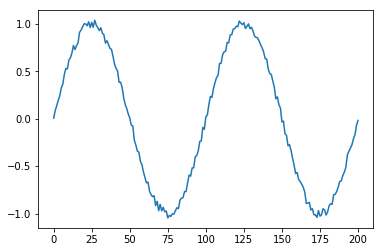

In [17]:
T = 100
f = toy_problem(T)

# 学習させるデータ
plt.plot(f)
plt.show()

In [18]:
length_of_sequences = 2 * T
maxlen = 25  #　学習させる時刻数

data = []
target = []

for i in range(0, length_of_sequences - maxlen + 1):
    data.append(f[i: i + maxlen])#f[i]からf[i+maxlen-1]の値を格納
    target.append(f[i + maxlen])#f[i+maxlen]の値を格納

In [19]:
#kerasのRNNへの入力のshapeが(batch_size, timesteps, input_dim)の3階テンソルなのでレイヤーを末に足します
X = np.array(data).reshape(len(data), maxlen, 1)
Y = np.array(target).reshape(len(data), 1)

X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=0.1)

## 2-2.入力と出力
今回はyの値を直近25stepを入力とし、次時刻の値を予測するモデルを作ります。<br>
なので、学習に用いるデータは以下のようになります。

- X_train: shape (None, 25,1)
- Y_train: shape (None, 1)




# 2-3.kerasによるRNNの実装

## モデルの定義

In [8]:
n_hidden = 20 # RNNの隠れ層次元

inp = Input(shape=(maxlen,1))
out = SimpleRNN(n_hidden, kernel_initializer='random_uniform')(inp)    #return_sequence=Trueの場合、各timeごとの隠れ層が返り値となります
out = Dense(1,activation='linear',kernel_initializer='random_uniform',)(out)   #次の値を予測するので出力は1  

model = Model(inputs=inp, outputs=out)


optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
model.compile(loss='mean_squared_error',
              optimizer=optimizer)

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 25, 1)             0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 20)                440       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 461
Trainable params: 461
Non-trainable params: 0
_________________________________________________________________


### 学習

In [10]:
epochs = 50
batch_size = 10

model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_validation, Y_validation),
          )



Train on 158 samples, validate on 18 samples
Epoch 1/50
158/158 [==============================] - 0s 2ms/step - loss: 0.4665 - val_loss: 0.3239
Epoch 2/50
158/158 [==============================] - 0s 1ms/step - loss: 0.3429 - val_loss: 0.2092
Epoch 3/50
158/158 [==============================] - 0s 1ms/step - loss: 0.1714 - val_loss: 0.0851
Epoch 4/50
158/158 [==============================] - 0s 1ms/step - loss: 0.0704 - val_loss: 0.0388
Epoch 5/50
158/158 [==============================] - 0s 1ms/step - loss: 0.0429 - val_loss: 0.0390
Epoch 6/50
158/158 [==============================] - 0s 1ms/step - loss: 0.0356 - val_loss: 0.0422
Epoch 7/50
158/158 [==============================] - 0s 1ms/step - loss: 0.0295 - val_loss: 0.0269
Epoch 8/50
158/158 [==============================] - 0s 1ms/step - loss: 0.0235 - val_loss: 0.0216
Epoch 9/50
158/158 [==============================] - 0s 1ms/step - loss: 0.0193 - val_loss: 0.0194
Epoch 10/50
158/158 [==============================] - 

# 2-4.学習結果の可視化

前時刻の出力を次の入力とすることで再帰的に出力する。

In [11]:
truncate = maxlen
Z = X[:1]  # 元データの最初の一部だけ切り出し
original = [f[i] for i in range(maxlen)]
predicted = [None for i in range(maxlen)]
timesteps=250

for i in range(timesteps):
    z_ = Z[-1:]#f[i]からf[i+maxlen-1]までの値
    y_ = model.predict(z_)#予想したf[i+maxlen]の値
    sequence_ = np.concatenate(
        (z_.reshape(maxlen, 1)[1:], y_),
        axis=0).reshape(1, maxlen, 1)#f[i+1]からf[i+maxlen]までの値
    Z = np.append(Z, sequence_, axis=0)
    predicted.append(y_.reshape(-1))#



In [20]:
Z.shape

(251, 25, 1)

In [21]:
X.shape

(176, 25, 1)

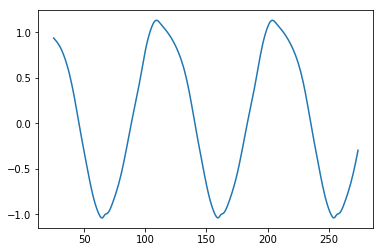

In [219]:
plt.plot(predicted)
plt.show()

# 3,RNNフルスクラッチ

In [279]:
#  Random orthogonal initializer (see [Saxe et al. 2013])
def orthogonal_initializer(shape, scale = 1.0):
    a = np.random.normal(0.0, 1.0, shape).astype(np.float32)
    u, _, v = np.linalg.svd(a, full_matrices=False)
    q = u if u.shape == shape else v
    return scale * q



In [280]:
rng = np.random.RandomState(1234)

class RNN:
    def __init__(self, in_dim, hid_dim):
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        # Xavier initializer
        self.W_in = tf.Variable(rng.uniform(
                        low=-np.sqrt(6/(in_dim + hid_dim)),
                        high=np.sqrt(6/(in_dim + hid_dim)),
                        size=(in_dim, hid_dim)
                    ).astype('float32'), name='W_in')
        # Random orthogonal initializer
        self.W_re = tf.Variable(orthogonal_initializer((hid_dim, hid_dim)), name='W_re')
        self.b_re = tf.Variable(tf.zeros([hid_dim], dtype=tf.float32), name='b_re')
        

    def f_prop(self, x):
        def fn(h_tm1, x):
            h_t = tf.nn.tanh(tf.matmul(h_tm1, self.W_re) + tf.matmul(x, self.W_in) + self.b_re)
            return h_t 
        
        # shape: [batch_size, sentence_length, in_dim] -> shape: [sentence_length, batch_size, in_dim]
        _x = tf.transpose(x, perm=[1, 0, 2])
        
        # shape: [batch_size, sentence_length] -> shape: [sentence_length, batch_size]
        h_0 = tf.matmul(x[:, 0, :], tf.zeros([self.in_dim, self.hid_dim])) # Initial state
        
        h = tf.scan(fn=fn, elems=_x, initializer=h_0)
        
        return h[-1] # Take the last state



## 補足：グラフ上でのLoop

tensorflowの計算グラフ上でloop構造を実現するには, `tf.scan`関数を使用します

#### tf.scan関数
- 主な引数
    - fn: 入力系列に適用する関数
    - elems: 入力系列 (第0軸方向に走査していく)
    - initializer: 最初の引数
    
参考:
https://www.tensorflow.org/api_docs/python/tf/scan

#### tf.scanの機能と注意事項

まず, 入力系列に対して適用する関数fnは, fn(a, x)といった様に, 2つの引数を持つものである必要があります.

この2つの引数にはそれぞれ役割があり, 次のようになっています.
  - 第1引数: 前ステップのfnの出力
  - 第2引数: 今ステップの入力(elems)
  
つまり, 出力される系列は, 例えばelemsの長さがNであれば,

$f_1={\rm fn}(initializer, elems[0])$

$f_2={\rm fn}(f_1, elems[1])$

$f_3={\rm fn}(f_2, elems[2])$

$\vdots$

$f_N={\rm fn}(f_{N-1}, elems[N-1])$

ということになります.

#### 例: initializer
* tf.scanのinitializerという引数で，loop構造の初期値を明示的に指定します．特にinitializerが指定されない場合は，上記のように入力系列の最初が初期値となります．

In [281]:
x = (tf.placeholder(tf.float32), tf.placeholder(tf.float32))
init = tf.placeholder(tf.float32)

def fn(a, x):
    return x[0] - x[1] + a

res = tf.scan(fn=fn, elems=x, initializer=init)

In [282]:
elems = np.array([1, 2, 3, 4, 5, 6])
with tf.Session() as sess:
    print(sess.run(res, feed_dict={
            x: (elems+1, elems),
            init: np.array(0)
    }))

[ 1.  2.  3.  4.  5.  6.]


In [283]:
class Dense:
    def __init__(self, in_dim, out_dim, function=lambda x: x):
        # Xavier initializer
        self.W = tf.Variable(rng.uniform(
                        low=-np.sqrt(6/(in_dim + out_dim)),
                        high=np.sqrt(6/(in_dim + out_dim)),
                        size=(in_dim, out_dim)
                    ).astype('float32'), name='W')
        self.b = tf.Variable(np.zeros([out_dim]).astype('float32'))
        self.function = function

    def f_prop(self, x):
        #return self.function(tf.matmul(x, self.W) + self.b)
        return tf.matmul(x, self.W) + self.b

#### 計算グラフの構築

In [284]:
hist_steps=25
x = tf.placeholder(tf.float32, [None, hist_steps,1], name="input_x")
t = tf.placeholder(tf.float32, [None, 1], name="input_y")

layers = [
    RNN(1, 20),
    Dense(20, 1)
]

def f_props(layers, x):
    for i, layer in enumerate(layers):
        x = layer.f_prop(x)
    return x

y = f_props(layers, x)

In [285]:
cost =  tf.reduce_mean(tf.square(y - t))
train = tf.train.AdamOptimizer().minimize(cost)



In [286]:
train_y=Y_train[:,np.newaxis]

In [290]:
n_epochs = 50
batch_size = 10
n_batches = X_train.shape[0]//batch_size

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

print("学習開始")    
for epoch in range(n_epochs):
    x_train, y_train = shuffle(X_train, train_y)
    
    for i in range(n_batches):
       
        start = i * batch_size
        end = start + batch_size
        
        x_batch = X_train[start:end]
        y_batch = Y_train[start:end]
        
        
        _, train_cost = sess.run([train, cost], feed_dict={x:x_batch, t: y_batch})
      
    if epoch%10==0:     
        print(" epoch "+str(epoch+1))
        print(train_cost)
    

学習開始
 epoch 1
0.0591665
 epoch 11
0.00227107
 epoch 21
0.00171229
 epoch 31
0.00156141
 epoch 41
0.00132832


In [291]:
truncate = maxlen
Z = X[:1]  # 元データの最初の一部だけ切り出し
original = [f[i] for i in range(maxlen)]
predicted = [None for i in range(maxlen)]
timesteps=250

for i in range(timesteps):
    z_ = Z[-1:]#f[i]からf[i+maxlen-1]までの値
    y_ = sess.run(y, feed_dict={x:z_})#予想したf[i+maxlen]の値
    sequence_ = np.concatenate(
        (z_.reshape(maxlen, 1)[1:], y_),
        axis=0).reshape(1, maxlen, 1)#f[i+1]からf[i+maxlen]までの値
    Z = np.append(Z, sequence_, axis=0)
    predicted.append(y_.reshape(-1))#




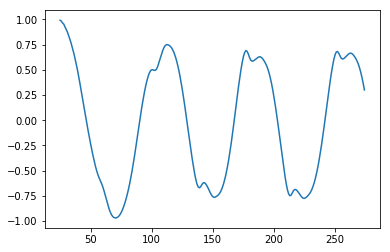

In [292]:
plt.plot(predicted)
plt.show()